# Jane Street Ongoing EDA

<img src="https://images.wsj.net/im-64845?width=300" />


In [ ]:
!pip install --quiet datatable
!pip install --quiet stumpy
!pip install --quiet yfinance

In [ ]:
import datatable as dt
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stumpy
import yfinance
import matplotlib
import matplotlib.cm as cm
from scipy.cluster import hierarchy as hc
from scipy.stats import spearmanr
import missingno

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = [16, 5]  # width, height

In [ ]:
%%time

train_data_datatable = dt.fread('../input/jane-street-market-prediction/train.csv')

In [ ]:
%%time

train_data = train_data_datatable.to_pandas()

In [ ]:
train_data.info()

Since we don't care about situations when weight==0, I am dropping all those. This is a topic of debate. 

In [ ]:
train_data = train_data.query('weight > 0')

In [ ]:
train_data.info()

In [ ]:
train_data.head()

## How many trades per day?

A lot! The US equity market has the most liquid stocks of any market in the world. If the time horizon is daily, and this were a single market you would not expect to see more than ~3000 line items per day. We see much more than that.

In [ ]:
cnt = train_data[['date', 'weight']].groupby('date').agg(['count'])
cnt_mean = cnt.mean().values[0]
cnt.plot(legend=False, title='Trades per Day (train)');
plt.axhline(cnt_mean, linestyle='--', alpha=0.85, c='r');

## What kind of market regime are we in in train?

We can make an index-like return series by averaging the daily returns and cumulating them. Perhaps it makes sense to use `weight` as an index weight. I am not doing that here though. I am assuming that the days are contiguous but there is reason to believe that they are not.

Trades are generally positive (mean) by about 4bps. 

To me this means we should be doing some **target engineering**. In train we are in an upward trending market. Who knows if that will be the case in the out-of-sample period. Perhaps de-meaning `resp` before binarizing it.

In [ ]:
train_data['resp'].mean()

I've read in the discussion that the time periods are disjoint, so cumulating this may not make sense; but, let's see anyhow.

In [ ]:
daily_avg_ret = train_data[['date', 'resp']].groupby('date').agg(['mean'])
daily_avg_ret.plot(
    title=f'Daily mean market return of {daily_avg_ret.mean().values[0]}'
);

In [ ]:
cumu_series = (1 + daily_avg_ret).cumprod()
cumu_series.plot(legend=False, title='"Market" return over train period');

## Can we match this market to a particular point in time?

TLDR: not really.

This is admitedly a little goofy, but let's try anyway.

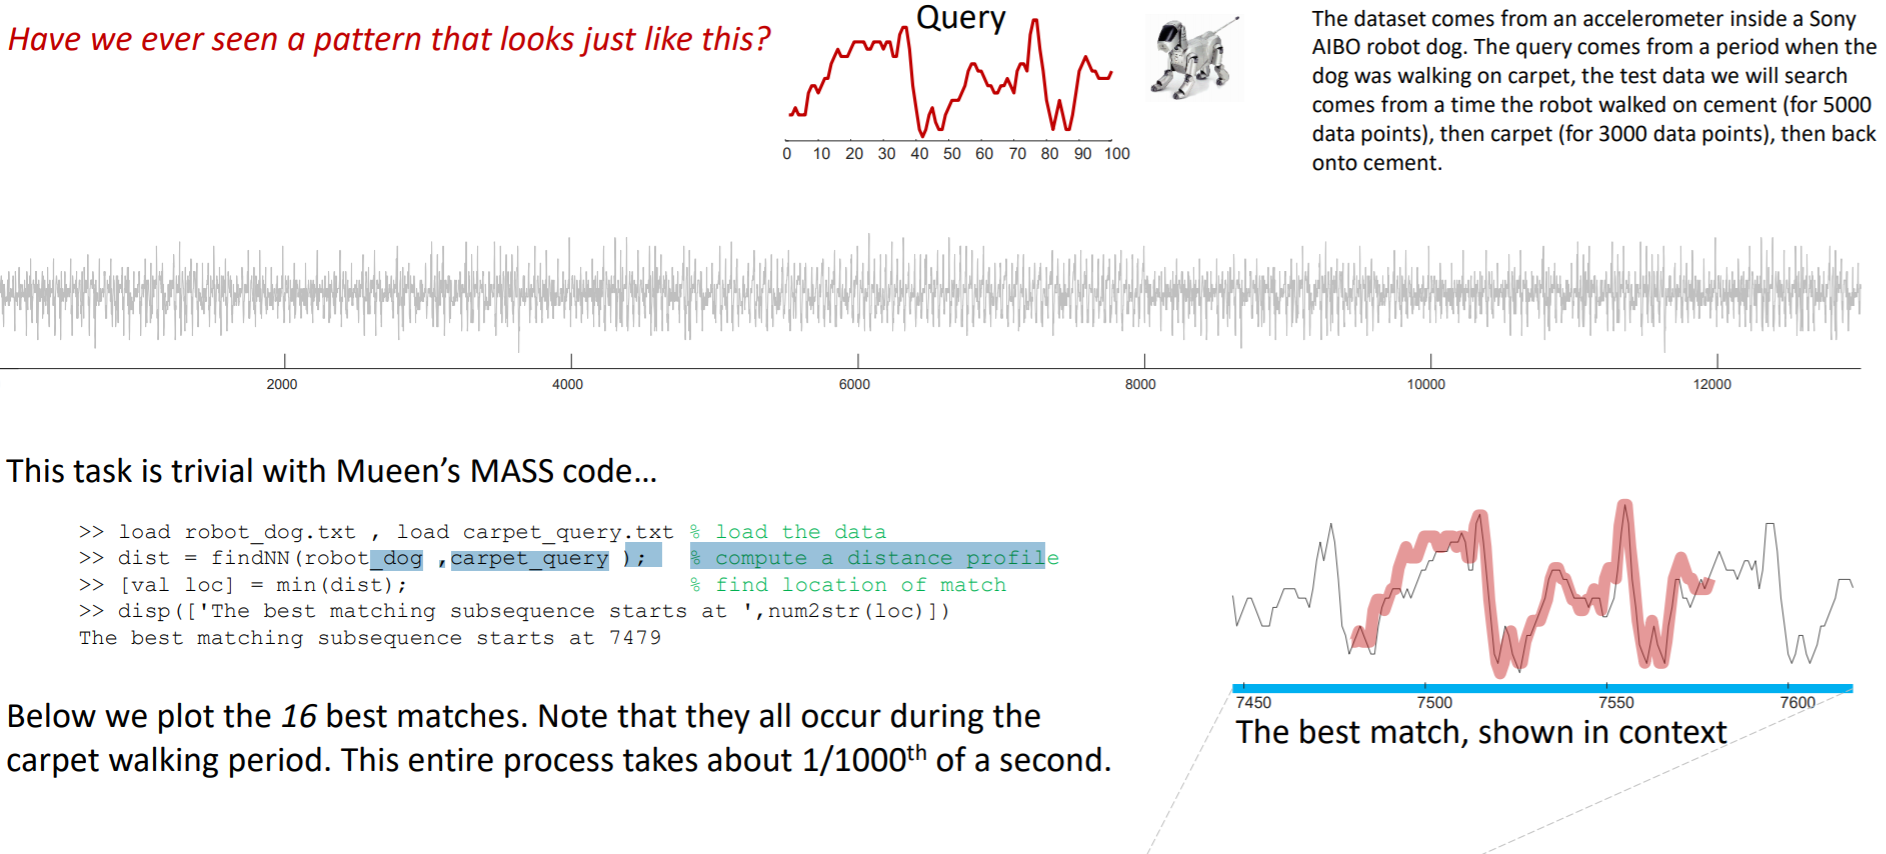

We can use `stumpy` for this (https://stumpy.readthedocs.io/en/latest/Tutorial_Pattern_Searching.html).

We assume (?) these are US equities and the market is proxied by S&P500 (SPY)

In [ ]:
raw_data = yfinance.download('SPY', start='2002-12-01', threads=True) 
raw_data.head()

In [ ]:
spy = raw_data['Adj Close']

In [ ]:
spy.plot()

In [ ]:
spy_ret = spy.pct_change()

Here we get the distance profile between the two return time series. Then we find the overlap where the distance is the smallest.

In [ ]:
distance_profile = stumpy.core.mass(daily_avg_ret.iloc[:, 0], spy_ret)

In [ ]:
idx = np.argmin(distance_profile)

print(f'The nearest neighbor to our "market" is located at index {idx} in SPY')
print(f'This is the date starting {spy_ret.index[idx]}')

In [ ]:
spy_series = spy.iloc[idx:(idx+499)].reset_index(drop=True)/spy.iloc[idx]

plt.plot(spy_series)
plt.plot(cumu_series)

This is not super convincing. It's unlikely we are being given days from 2012... to be continued. I think rather these are just samples of days and stocks fron many years of history.

## Feature Cardinality

Which features are categorical?

TLDR.... just feature_0

In [ ]:
all_columns = train_data.columns
columns = all_columns[train_data.columns.str.contains('feature')]

In [ ]:
%%time
cardinality = train_data[columns].nunique()

In [ ]:
cardinality.sort_values()

The smallest cardinality is > 20000 after feature_0. So it appears that none of these features, except, feature_0, is categorical. I was expecting more -- like sector, subsector, etc. Just checking....

In [ ]:
train_data['feature_43'].hist(bins=50)

In [ ]:
train_data['feature_43']

So, no categoricals.

## Feature Clustering with Tags

[This insightful comment from the host ](https://www.kaggle.com/c/jane-street-market-prediction/discussion/198965#1088878) leads me to believe we should be able to figure out which tags are days in history and which will allow us to do some sensible feature combination.

The first steps to this are to cluster features. We use **spearman rank correlation**. Generally, Spearman is the best thing to use in financial data problems. Also using a rank statistic is consistent with decision tree based learners which are simply splitting and are invariant to range. Then we plot the heirarchy of the spearman rank correlation matrix.

First we need some feature importances. I will get them from LightGBM.

In [ ]:

nsamples = len(train_data)
train_cut = int(nsamples*0.80)

threshold = 0.0004  # this is like de-meaning

y = (train_data['resp'].values > threshold).astype(int)

y_valid = y[(train_cut+1):]

dTrain = lgb.Dataset(train_data[list(columns)][0:train_cut], y[0:train_cut])
validationSet = lgb.Dataset(train_data[list(columns)][(train_cut+1):], y[(train_cut+1):])

params = {
    'min_child_samples': 100,
    'objective': 'binary',
    'max_depth': 8,
    'learning_rate': 0.05,
    'boosting_type': "gbdt",
    'subsample_freq': 10,
    'subsample': 0.33,
    'bagging_seed': 42,
    'metric': 'binary_logloss',
    'feature_fraction': 0.80,
    'extra_trees': False    # can't get this to work; it's in version 3.0+; we are less than that
}

In [ ]:
%%time
model = lgb.train(
    params,
    dTrain,
    500,
    early_stopping_rounds = 100,
    valid_sets = [validationSet],
    verbose_eval = 50
)

Reminder: log loss of 0.693 is random guessing. https://towardsdatascience.com/estimate-model-performance-with-log-loss-like-a-pro-9f47d13c8865

I am going to sample days. Importantly, not sampling rows -- we need to keep the days together, I believe, to preserve the full cross section of the securities where available.

In [ ]:
# pick a random sample of days
sample_days = np.random.choice(np.arange(499), 50)

In [ ]:
%%time
corr = np.round(spearmanr(train_data.query('date in @sample_days').fillna(-999)).correlation, 4)

Lots of kernels plot a corr matrix; not that helpful IMHO :-).

In [ ]:
plt.matshow(corr);

However, what can be helpful is to cluster this matrix **and to show the feature importance**.

In [ ]:
corr[np.isnan(corr)] = 0
corr_condensed = hc.distance.squareform(1-corr, checks=True)
z = hc.linkage(corr_condensed, method='average')

There is probably some better pandas magic to do this, but here we go. I make a label string of the feature name and the associated tags.

In [ ]:
tags = pd.read_csv('../input/jane-street-market-prediction/features.csv')
tag_names = tags.copy()

for index, row in tags.iterrows():
    for i in range(29):
        if row[i+1] == True:
            tag_names.iloc[index, i+1] = row.index[i+1]
        else:
            tag_names.iloc[index, i+1] = np.nan

ndf = pd.DataFrame([r.str.cat(sep=",") for i, r in tag_names.iloc[:,0:].iterrows()])
flat_list = ['date', 'weight', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp'] + \
    [item for sublist in ndf.values for item in sublist] + \
    ['ts_id']
flat_list = [sub.replace(',', ' ') for sub in flat_list]

In [ ]:
importances = model.feature_importance()
minima = min(importances) - 0.20*(max(importances) - min(importances))
maxima = max(importances)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Greys)

In [ ]:
ignore = ['resp', 'resp_1', 'resp_4', 'resp_3', 'resp_2', 'weight', 'ts_id', 'date']
pruned = [x for x in flat_list if x not in ignore]

In [ ]:
fig = plt.figure(figsize=(12,30))
dendrogram = hc.dendrogram(z, labels=flat_list, orientation='left', leaf_font_size=10)

ax = plt.gca()
ylbls = ax.get_ymajorticklabels()
for lbl in ylbls:
    try:
        imp = importances[pruned.index(lbl.get_text())]
        lbl.set_color(mapper.to_rgba(imp))
    except:
        lbl.set_color('r')
plt.title('Features Clustered; Tags Noted; Label Color is f(lgb feature importance)')
plt.show()

**The darker labels represent features that have higher feature importance in the LightGBM model.**

What do we do with this?

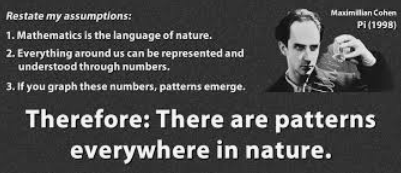


- we can drop a feature where we see a feature pair which implies there is redundant information. This can speed training and inference in tree models, make a model more robust to overfitting, and reduce collinearity in linear models.

For example, the relationship and inclusion of **feature_61** and **feature_60** should be investigated.

- also we can get some intution on what the tags might be and use that to make additional features. Based on the clustering above, I am going to speculate that tags 0, 1, 2, 3, 4 relate to historical time periods. Why? Let's imagine that we have a feature like the trailing standard deviation of returns (a very common financial feature; aka historic volatility of a stock/security); let's call this function `hist_vol(n_days_history)`. The rank correlations of `hist_vol(30 days)`, `hist_vol(15 days)`, and `hist_vol(10 days)` will be very high because the days overlap. The tags for the set of anonymized `hist_vol` features would look something like:
    - feature 1 (which is `hist_vol(30)`): tag A, tag J
    - feature 2 (which is `hist_vol(15)`): tag B, tag J
    - feature 3 (which is `hist_vol(10)`): tag C, tag J

As such, we will see one tag repeated (in this case "J") to indicate this is a volatility feature. Then we would see tags indicating the 10, 15, 30 day histories (in this case, "A", "B" "C"). If tags A, B, C represent different historic periods, then we should see A,B,C again for other time series features.


In [ ]:
feat_1 = 'feature_42'
feat_2 = 'feature_43'
plt.scatter(train_data[feat_1], train_data[feat_2]);

In [ ]:
feat_1 = 'feature_60'
feat_2 = 'feature_61'
plt.scatter(train_data[feat_1], train_data[feat_2]);

In [ ]:
feat_1 = 'feature_65'
feat_2 = 'feature_66'
plt.scatter(train_data[feat_1], train_data[feat_2]);

In [ ]:
feat_1 = 'feature_83'
feat_2 = 'feature_77'

plt.scatter(train_data[feat_1], train_data[feat_2]);


In [ ]:
feat_1 = 'feature_7'
feat_2 = 'feature_8'

plt.scatter(train_data[feat_1], train_data[feat_2]);

In [ ]:
feat_1 = 'feature_27'
feat_2 = 'feature_28'

plt.scatter(train_data[feat_1], train_data[feat_2]);

In [ ]:
feat_1 = 'feature_57'
feat_2 = 'feature_58'

plt.scatter(train_data[feat_1], train_data[feat_2]);

In [ ]:
feat_1 = 'feature_122'
feat_2 = 'feature_128'

plt.scatter(train_data[feat_1], train_data[feat_2]);

In [ ]:
feat_2 = 'feature_51'
feat_1 = 'weight'

plt.scatter(train_data[feat_1], train_data[feat_2]);
plt.xlabel(feat_1)
plt.ylabel(feat_2);

In [ ]:
import seaborn as sns
train_data['target'] = ((train_data['resp']*train_data['weight']) > 0).astype(int)
sns.pairplot(
    train_data.query('date in @sample_days')[[f'feature_{x}' for x in [42, 43]] + ['target']],
    plot_kws={'alpha': 0.1},
    #hue='target'
);


## The relationship between weight and resp

This is interesting. Lower weight trades have a much higher dispersion in resp. **This implies that weight is some kind of (valid) predictor of future return volatility**. 

In [ ]:
feat_1 = 'weight'
feat_2 = 'resp'
plt.scatter(train_data[feat_1], (train_data[feat_2]));
plt.xlabel(feat_1)
plt.ylabel(feat_2);

Comments and questions welcome. Thank you for reading.